# 学習方法の例

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

In [2]:
import os
# import sqlite3
import configparser
import mlflow
import mlflow.sklearn

In [3]:
cfg = configparser.ConfigParser()
cfg.read('./config.ini', encoding='utf-8')
# 各種パスを指定
# DB_PATH = cfg['Path']['db_path']

['./config.ini']

In [4]:
# %% エクスペリメントの作成
# Artifactストレージの場所を指定
ARTIFACT_LOCATION = cfg['Path']['artifact_location']
# Experimentの生成
EXPERIMENT_NAME = 'experiment_tuning'
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:  # 当該Experiment存在しないとき、新たに作成
    experiment_id = mlflow.create_experiment(
                            name=EXPERIMENT_NAME,
                            artifact_location=ARTIFACT_LOCATION)
else: # 当該Experiment存在するとき、IDを取得
    experiment_id = experiment.experiment_id

In [5]:
# # トラッキングサーバの場所
# tracking_uri = mlflow.get_tracking_uri()
# print('Current tracking uri: {}'.format(tracking_uri))
# # レジストリサーバの場所
# mr_uri = mlflow.get_registry_uri()
# print('Current model registry uri: {}'.format(mr_uri))
# # Artifactストレージの場所
# artifact_uri = mlflow.get_artifact_uri()
# print('Current artifact uri: {}'.format(artifact_uri))

In [6]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# import pickle

# try:
#     from google.colab import files
#     print('Google Colab. 上での実行です')
#     print('「ファイルを選択」から、2_notebook/commonのlayers.pyを選択し、アップロードしてください')
#     print('===========')
#     files.upload()
#     !mkdir common
#     !mv *.py ./common
#     print('次に 1_dataのtrain_data.npy、train_label.npyを選択し、アップロードしてください')
#     print('===========')
#     files.upload()
#     !mkdir ../1_data
#     !mv *.npy ../1_data
# except:
#     print('ローカル環境での実行です')


# from common.layers import TwoLayerNet

## データを読む1

In [7]:
train_data = np.load("../1_data/train_data.npy")
train_label = np.load("../1_data/train_label.npy")
print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)


In [8]:
# 正規化
train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')
# print(train_data)

In [9]:
# 配列形式変更
train_data = train_data.reshape(-1, 28*28)
print("train_data.shape=", train_data.shape)

train_data.shape= (3000, 784)


## trainとtestに分割する

In [10]:
X_train_all, X_test, y_train_all, y_test = train_test_split(train_data, train_label, 
                                                    test_size=0.3, random_state=1234,
                                                    shuffle=True
                                                   )

print(X_train_all.shape, X_test.shape)

(2100, 784) (900, 784)


In [11]:
# データを間引く
# X_train = X_train_all[:1000,:]
# y_train = y_train_all[:1000,:]
X_train = X_train_all
y_train = y_train_all
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2100, 784) (900, 784)
(2100, 15) (900, 15)


## 学習

In [12]:
# 勾配の比較方法。当面使わないので抜粋してコメントアウト
#             # 勾配の計算
#             grads = tnet.gradient(x_, y_)

#     #         # 勾配の比較（通常はコメントアウト）
#     #         # diffの値がほぼゼロであれば誤差逆伝播法が正しく実装できている
#     #         grad_numerical = tnet.numerical_gradient(x_, y_)
#     #         for key in grad_numerical.keys():
#     #             diff = np.average(np.abs(grads[key] - grad_numerical[key]))
#     #             print(key + ":" + str(diff))
    
#     #         break    


In [36]:
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, RMSProp

def __train(weight_init_std, ecpochs, batch_size):
    
    # バッチ正規化ありのネットワーク
    bn_network = MultiLayerNetExtend(
                                input_size=784,
                                hidden_size_list=[100, 100, 100, 100, 100],
                                output_size=15, 
                                weight_init_std=weight_init_std,
                                use_batchnorm=True)
#     tnet = TwoLayerNet(input_size=28*28, hidden_size=10, output_size=15)
    
    # バッチ正規化なしのネットワーク
    network = MultiLayerNetExtend(
                                input_size=784,
                                hidden_size_list=[100, 100, 100, 100, 100],
                                output_size=15,
                                weight_init_std=weight_init_std)
    
    # 最適化手法
#     optimizer = SGD(lr=learning_rate) # 学習初期で発散する場合がある
    optimizer = RMSProp(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    xsize = X_train.shape[0]
    iter_num = np.ceil(xsize / batch_size).astype(int)
    
    # シードを固定
    np.random.seed(random_seed)
    seeds = np.random.randint(0, epochs-1, epochs)

    for epoch in range(epochs):
        if np.mod(epoch,10)==0 : print("**epoch=%s"%epoch)
            
        # シードを固定
        np.random.seed(seeds[epoch])
        # シャッフル
        idx = np.arange(xsize)
        np.random.shuffle(idx)

        for it in range(iter_num):
            """
            ランダムなミニバッチを順番に取り出す
            """
            mask = idx[batch_size*it : batch_size*(it+1)]

            # ミニバッチの生成
            X_batch = X_train[mask]
            y_batch = y_train[mask]

            for _network in (bn_network,network): 
                # 勾配の計算
                grads = network.gradient(X_batch, y_batch)
        
                # パラメータの更新
                optimizer.update(network.params, grads)

        # 精度評価
        train_acc = network.accuracy(X_train, y_train)
        bn_train_acc = bn_network.accuracy(X_train, y_train)
        train_acc_list.append(train_acc)
        bn_train_acc_list.append(bn_train_acc)

    return train_acc_list, bn_train_acc_list

In [37]:
# from common.layers import TwoLayerNet
# def model_train(epochs, batch_size, lr, random_seed):
#     # 繰り返し回数
#     xsize = X_train.shape[0]
#     iter_num = np.ceil(xsize / batch_size).astype(int)

#     # 2層NNのオブジェクト生成
#     tnet = TwoLayerNet(input_size=28*28, hidden_size=10, output_size=15)

#     train_loss = []; test_loss = []; train_accuracy = []; test_accuracy = []
    
#     # シードを固定
#     np.random.seed(random_seed)
#     seeds = np.random.randint(0, epochs-1, epochs)

#     for epoch in range(epochs):
#         if np.mod(epoch,10)==0 : print("**epoch=%s"%epoch)

#         # シードを固定
#         np.random.seed(seeds[epoch])
        
#         # シャッフル
#         idx = np.arange(xsize)
#         np.random.shuffle(idx)

#         for it in range(iter_num):
#             """
#             ランダムなミニバッチを順番に取り出す
#             """
#             mask = idx[batch_size*it : batch_size*(it+1)]

#             # ミニバッチの生成
#             x_ = X_train[mask]
#             y_ = y_train[mask]
            
#             # 勾配の計算
#             grads = tnet.gradient(x_, y_)

#             # パラメータの更新
#             for key in tnet.params.keys():
#                 tnet.params[key] -= lr * grads[key]

#         # 訓練データおよびテストデータにおけるlossを記録
#         train_loss.append(tnet.loss(X_train,  y_train)); test_loss.append(tnet.loss(X_test, y_test))

#         # 訓練データおよびテストデータにおける精度を記録
#         train_accuracy.append(tnet.accuracy(X_train, y_train)); test_accuracy.append(tnet.accuracy(X_test, y_test))
        
#     return tnet, train_accuracy, test_accuracy, train_loss, test_loss

In [40]:
epochs = 20
batch_size = 32#100
learning_rate = 0.01
random_seed = 1234

# 重みwの初期値を決める時の標準偏差を16パターン生成する
weight_scale_list = np.logspace(0, -4, num=16, base=10.0) # 常用対数
print("weight_scale_list=", weight_scale_list.round(5))

dic_train_acc_list = {}
dic_bn_train_acc_list = {}

# 学習
for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w, epochs, batch_size)
    # train_acc_list = __train(w, epochs, batch_size)
    dic_train_acc_list[i] = train_acc_list
    dic_bn_train_acc_list[i] = bn_train_acc_list 
    

weight_scale_list= [1.0000e+00 5.4117e-01 2.9286e-01 1.5849e-01 8.5770e-02 4.6420e-02
 2.5120e-02 1.3590e-02 7.3600e-03 3.9800e-03 2.1500e-03 1.1700e-03
 6.3000e-04 3.4000e-04 1.8000e-04 1.0000e-04]
============== 1/16 ==============
**epoch=0
**epoch=10
============== 2/16 ==============
**epoch=0
**epoch=10
============== 3/16 ==============
**epoch=0
**epoch=10
============== 4/16 ==============
**epoch=0
**epoch=10
============== 5/16 ==============
**epoch=0
**epoch=10
============== 6/16 ==============
**epoch=0
**epoch=10
============== 7/16 ==============
**epoch=0
**epoch=10
============== 8/16 ==============
**epoch=0
**epoch=10
============== 9/16 ==============
**epoch=0
**epoch=10
============== 10/16 ==============
**epoch=0
**epoch=10
============== 11/16 ==============
**epoch=0
**epoch=10
============== 12/16 ==============
**epoch=0
**epoch=10
============== 13/16 ==============
**epoch=0
**epoch=10
============== 14/16 ==============
**epoch=0
**epoch=10
============

============== 1/16 ==============
============== 2/16 ==============
============== 3/16 ==============
============== 4/16 ==============
============== 5/16 ==============
============== 6/16 ==============
============== 7/16 ==============
============== 8/16 ==============
============== 9/16 ==============
============== 10/16 ==============
============== 11/16 ==============
============== 12/16 ==============
============== 13/16 ==============
============== 14/16 ==============
============== 15/16 ==============
============== 16/16 ==============


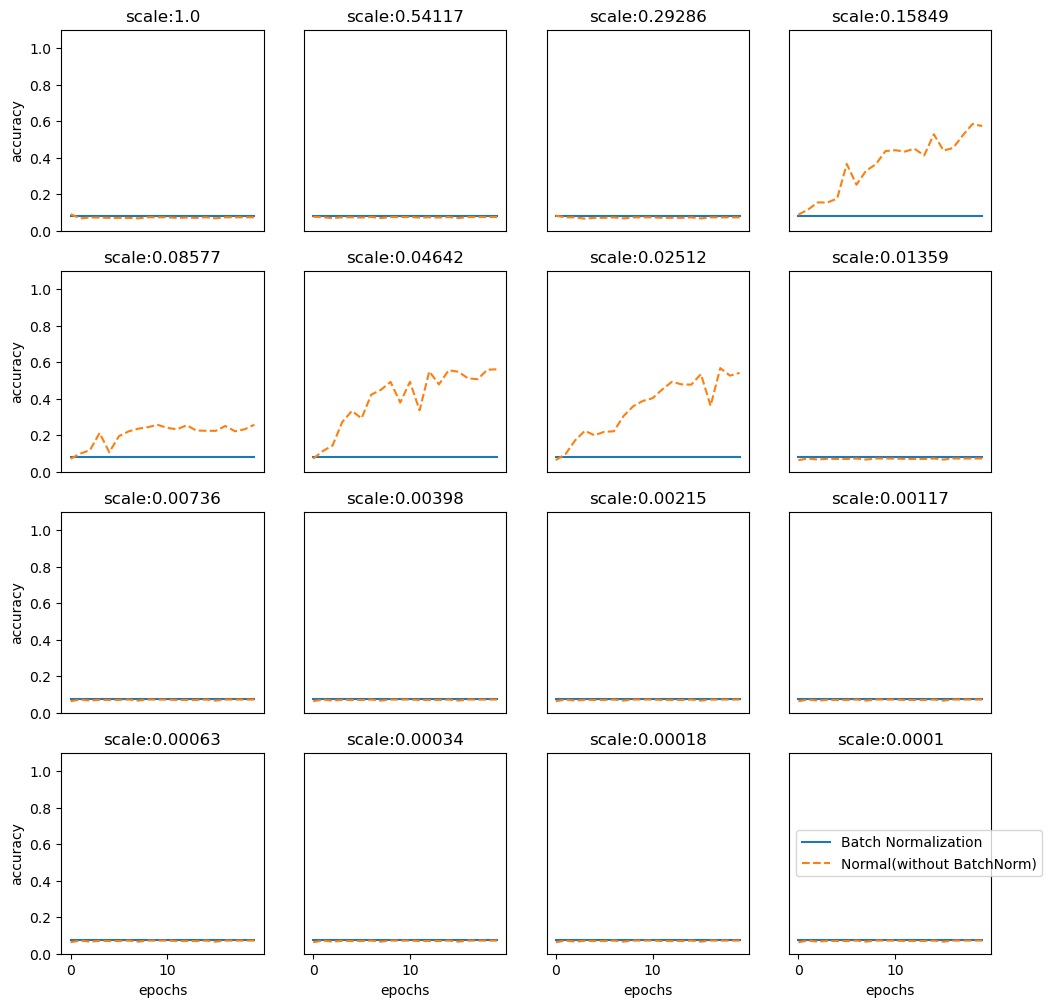

In [41]:
x = np.arange(epochs)
plt.figure(figsize=(12,12))

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    
    train_acc_list = dic_train_acc_list[i]
    bn_train_acc_list  = dic_bn_train_acc_list[i]

    plt.subplot(4,4,i+1)
    plt.title("scale:" + str(w.round(5)))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.1)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
        
    if i==15:
        plt.legend(loc='center left')
    
plt.show()

In [167]:
# mlflowに記録
epochs = 200
batch_size = 32
lr = 0.01
random_seed = 1234

mlflow.end_run()

# 管理IDを発行（コードの実行に対して）
with mlflow.start_run(experiment_id=experiment_id):
    trial = 0

    tnet, train_acc, test_acc, train_loss, test_loss = model_train(epochs, batch_size, lr, random_seed)

    # 小数点以下３桁まで出力
    print(f"trial {trial}: batch_size={batch_size}, lr={lr},　train_accuracy={train_acc[-1]:.3}, test_accuracy={test_acc[-1]:.3}")

    # ハイパーパラメータ, 評価指標, 学習済みモデルをMLflowへ保存
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("lr", lr)
    mlflow.log_metric("train_accuracy", train_acc[-1])
    mlflow.log_metric("test_accuracy", test_acc[-1])
    mlflow.log_param("random_seed", random_seed)

    # mlflow.log_model(tnet, "model")

# mlflowを終了
mlflow.end_run()

**epoch=0
**epoch=10
**epoch=20
**epoch=30
**epoch=40
**epoch=50
**epoch=60
**epoch=70
**epoch=80
**epoch=90
**epoch=100
**epoch=110
**epoch=120
**epoch=130
**epoch=140
**epoch=150
**epoch=160
**epoch=170
**epoch=180
**epoch=190
trial 0: batch_size=32, lr=0.01,　train_accuracy=0.971, test_accuracy=0.861


In [134]:
# mlflow.end_run()

In [86]:
# # mlflowに記録（グリッドサーチ）
# # 管理IDを発行（コードの実行に対して）
# experiment_id = 0
# with mlflow.start_run(experiment_id=experiment_id):
#     # ハイパーパラメータの試行水準
#     cand_batch_size = [16, 32]
#     cand_lr = [0.005, 0.01]

#     trial = 0
#     for batch_size in cand_batch_size:
#         for lr in cand_lr:
#             # 管理IDを発行（各パラメータ水準に対して）
#             with mlflow.start_run(experiment_id=experiment_id, nested=True):
#                 trial += 1
#                 tnet, train_accuracy, test_accuracy, train_loss, test_loss = model_train(epochs, batch_size, lr)
#                 # model, mse, R2 = train(n_estimators, max_depth)
#                 # 小数点以下３桁まで出力
#                 print(f"trial {trial}: batch_size={batch_size}, lr={lr}, \
#                       train_accuracy={train_accuracy[-1]:.3}, test_accuracy={test_accuracy[-1]:.3}")
#                 # 追加箇所
#                 # ハイパーパラメータ, 評価指標, 学習済みモデルをMLflowへ保存
#                 mlflow.log_param("batch_size", batch_size)
#                 mlflow.log_param("lr", lr)
#                 mlflow.log_metric("train_accuracy", train_accuracy[-1])
#                 mlflow.log_metric("test_accuracy", test_accuracy[-1])

#                 mlflow.sklearn.log_model(tnet, "model")


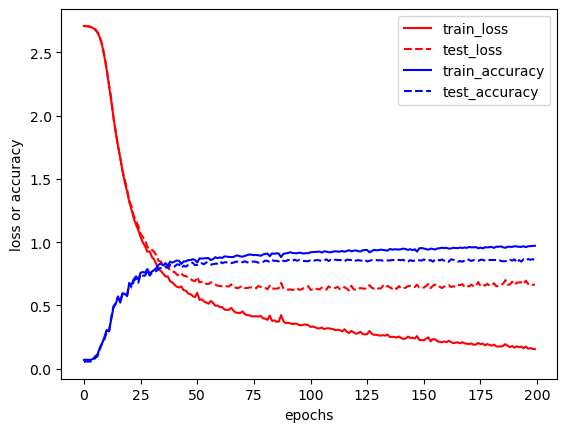

In [119]:
# lossのグラフ化
df_log = pd.DataFrame({"train_loss":train_loss,
             "test_loss":test_loss,
             "train_accuracy":train_acc,
             "test_accuracy":test_acc})
df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
plt.ylabel("loss or accuracy")
plt.xlabel("epochs")
plt.show()

## 学習済みモデルの出力

In [16]:
with open("katakana_model.pickle", "wb") as f:
    pickle.dump(tnet, f)

- Google Colab. を使用している人は `katakana_model.pickle` のダウンロードを忘れないようにしよう
  - 「識別精度算出ウェブサイト」への投稿に必要な情報であるため
  - ファイルダウンロードの参考：https://blog.kikagaku.co.jp/google-colab-file#_Google_Colab